In [1]:
import os
import ase
import json
import mendeleev
import pymatgen
import matplotlib.pyplot as plt
import pandas as pd


from pathlib import Path as path
from collections import defaultdict
from ase.visualize.plot import plot_atoms
from structure_featurization import featurize, featurize_expanded
from ase import io

In [2]:
def get_gpaw_trajectories(defect_db_path:str):
    res = defaultdict(list)
    for file_ in os.listdir(defect_db_path):
        if not file_.startswith("id"):
            continue
        this_folder = os.path.join(defect_db_path, file_, "relaxed", "trajectory")
        for traj_file in os.listdir(this_folder):
            try:
                res[file_].append(ase.io.read(os.path.join(this_folder, traj_file), index=":"))
            except ase.io.formats.UnknownFileTypeError:
                pass
    return res


dataset = get_gpaw_trajectories("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

In [3]:
dataset.keys()

dict_keys(['id43', 'id4', 'id34', 'id44', 'id38', 'id12', 'id31', 'id11', 'id22', 'id15', 'id16', 'id9', 'id27', 'id14', 'id7', 'id24', 'id1', 'id37', 'id13', 'id20', 'id35', 'id36', 'id17', 'id6', 'id28', 'id3', 'id45', 'id18', 'id23', 'id21', 'id5', 'id42', 'id46', 'id33', 'id25', 'id26', 'id30', 'id8', 'id19', 'id40', 'id10', 'id41', 'id29', 'id47', 'id39', 'id32', 'id0', 'id2'])

<AxesSubplot:>

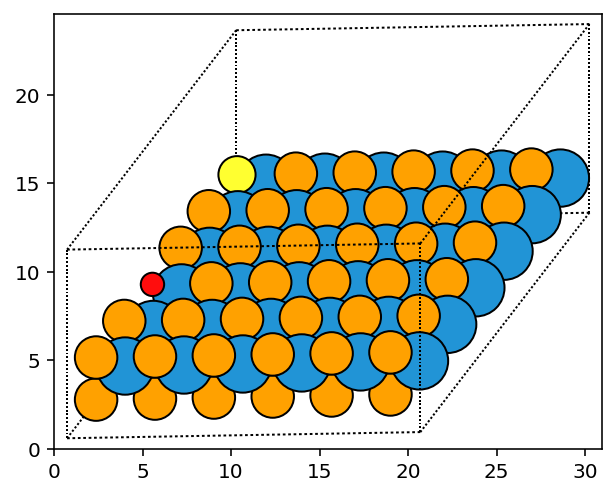

In [17]:
id_prop = []
defect = 'id2'
data_root = path(f'datasets/cgcnn_data_format/{defect}')
data_root.mkdir() if not data_root.exists() else None


def init_atom_feat(atoms: ase.Atom):
    
    def compute_species_params(charge):
        element = mendeleev.element(charge)
        return [charge, element.atomic_volume, element.group_id, element.period]     
    
    atoms_feat = dict()
    for atom, charge in zip(atoms, atoms.get_atomic_numbers()):
        atoms_feat[atom.index] = compute_species_params(int(charge))
        
    return json.dumps(atoms_feat)

matminer_feat = {}
for idx, item in enumerate(dataset[defect][0]):
    # id, target 
    id_prop.append(f'{idx}, {item.get_potential_energy()}\n')
    ase.io.write(data_root.joinpath(f'{idx}.cif'), item, 'cif')
    matminer_feat[idx] = featurize(pymatgen.io.ase.AseAtomsAdaptor.get_structure(item))

with open(data_root.joinpath('id_prop.csv'), 'w') as f:
    f.writelines(id_prop)
with open(data_root.joinpath('atom_init.json'), 'w') as f:
    f.writelines(init_atom_feat(dataset[defect][0][0]))
with open(data_root.joinpath('matminer_feat.json'), 'w') as f:
    f.writelines(json.dumps(matminer_feat))


torch.tensor(list(feat.values())).shape
plot_atoms(dataset[defect][0][0], rotation='135x,1y,1z')


In [72]:
# Train
# --resume model_best.pth.tar
%run cgcnn/main.py --optim Adam --lr 3e-3 --epochs 50 --train-size 8 --n-conv 24 --n-h 256  --val-size 1 --test-size 1  datasets/cgcnn_data_format/id2/
# %run cgcnn/main.py --epochs 500 --train-size 9 --val-size 1 datasets/cgcnn_data_format/id2/

[Warning] train_ratio is None, using all training data.


/home/aziz/ai4material_design/cgcnn/main.py:117: UserWarning: Dataset has less than 500 data points. Lower accuracy is expected. 
  warnings.warn('Dataset has less than 500 data points. '


Epoch: [0][0/1]	Time 0.125 (0.125)	Data 0.001 (0.001)	Loss 297790720.0000 (297790720.0000)	MAE 10284.651 (10284.651)
Test: [0/1]	Time 0.021 (0.021)	Loss 18647672832.0000 (18647672832.0000)	MAE 81385.359 (81385.359)
 * MAE 81385.359
Epoch: [1][0/1]	Time 0.125 (0.125)	Data 0.001 (0.001)	Loss 57240043520.0000 (57240043520.0000)	MAE 142588.312 (142588.312)
Test: [0/1]	Time 0.021 (0.021)	Loss 1910271744.0000 (1910271744.0000)	MAE 26048.432 (26048.432)
 * MAE 26048.432
Epoch: [2][0/1]	Time 0.126 (0.126)	Data 0.001 (0.001)	Loss 5035774976.0000 (5035774976.0000)	MAE 42292.871 (42292.871)
Test: [0/1]	Time 0.021 (0.021)	Loss 220433664.0000 (220433664.0000)	MAE 8848.566 (8848.566)
 * MAE 8848.566
Epoch: [3][0/1]	Time 0.125 (0.125)	Data 0.001 (0.001)	Loss 721025088.0000 (721025088.0000)	MAE 16003.286 (16003.286)
Test: [0/1]	Time 0.022 (0.022)	Loss 587432640.0000 (587432640.0000)	MAE 14444.850 (14444.850)
 * MAE 14444.850
Epoch: [4][0/1]	Time 0.126 (0.126)	Data 0.001 (0.001)	Loss 1624406528.0000 (1

<Figure size 432x288 with 0 Axes>

In [73]:
# Inference
%run cgcnn/predict.py model_best.pth.tar datasets/cgcnn_data_format/id2/

=> loading model params 'model_best.pth.tar'
=> loaded model params 'model_best.pth.tar'
=> loading model 'model_best.pth.tar'
=> loaded model 'model_best.pth.tar' (epoch 48, validation 3.49005126953125)
Test: [0/1]	Time 2.193 (2.193)	Loss 206607.2188 (206607.2188)	MAE 270.891 (270.891)
 ** MAE 270.891


In [74]:
results = pd.read_csv('test_results.csv', index_col=0, names=['index', 'target', 'predicted'])
print(results)


           target   predicted
index                        
15    -721.548889 -993.149902
11    -721.520874 -993.013550
13    -721.541565 -993.111572
6     -721.409119 -991.942688
0     -719.080383 -980.662842
4     -721.201477 -991.340454
21    -721.565247 -993.422729
10    -721.487915 -992.673584
5     -721.363525 -991.731201
27    -721.575317 -993.535889
24    -721.570618 -993.425415
9     -721.476807 -992.591797
8     -721.434387 -992.938354
25    -721.572449 -993.402100
17    -721.555481 -993.280151
22    -721.566895 -993.384216
16    -721.551941 -993.301270
14    -721.545227 -993.194824
2     -720.713379 -990.351624
18    -721.558350 -993.270935
20    -721.563538 -993.428955
23    -721.568481 -993.362915
7     -721.435547 -992.272949
19    -721.561096 -993.322632
1     -719.564270 -987.728760
3     -721.069031 -991.292847
12    -721.531494 -993.097717
26    -721.574280 -993.432434


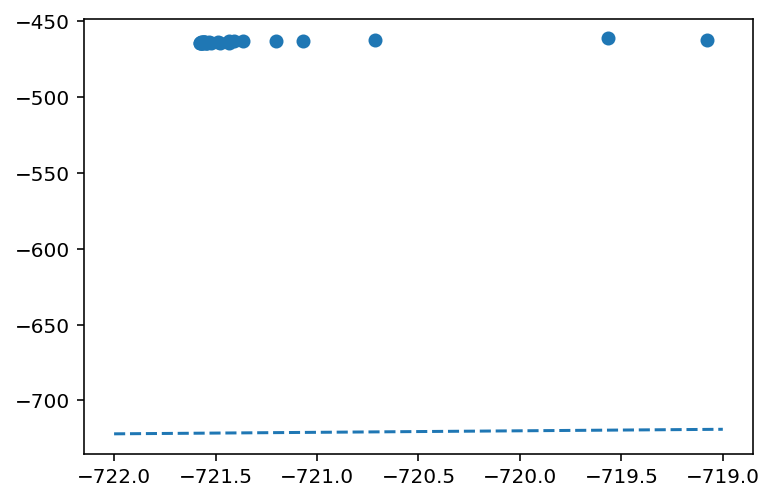

In [71]:
plt.plot([-722, -719], [-722, -719], '--')
plt.scatter(results['target'], results['predicted'])